# Cascadia Margin Lipid Modeling

In [1]:
from os.path import join
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## configuration

In [4]:
from matplotlib import style

In [5]:
style.use(join("..", "style.mplstyle"))
datadir = join("..", "data", "processed")

## load data

### relative abundance and d13C of GDGT compounds

In [6]:
df = pd.read_excel(join(datadir, "CascadiaMargin_carbon_abundance.xlsx"))
df.replace(
    {"Astoria Cyn": "Astoria Canyon", "Mcarthur cyn": "Mcarthur Canyon"}, inplace=True
)
df.sample(10)

Sample Name         Location    Compound  m_from_plume depth_int  \
194        S107  Mcarthur Canyon          G1            60       4-6   
197        S107  Mcarthur Canyon  Cren regio            60       4-6   
193        S107  Mcarthur Canyon          G0            60       4-6   
211        S112  Mcarthur Canyon          G0             0       3-4   
154         S97  Mcarthur Canyon          G3            30       0-1   
160         S99  Mcarthur Canyon          G3            30       2-3   
2            S1   Astoria Canyon          G1            20       0-1   
185        S105  Mcarthur Canyon  Cren regio            60       2-3   
28           S7   Astoria Canyon          G3             0       0-1   
168        S101  Mcarthur Canyon        Cren            30       4-6   

      avg_ugC     F2/F1    d13c_avg     stdev  purity_score  rel_abund  
194  2.971449  12.783936 -19.446246  0.042994      0.777527   0.068182  
197       NaN        NaN        NaN       NaN           NaN   0.011363  
193  5.629364  54.627066 -19.364876  0.060931      0.893562   0.488973  
211  6.492573  33.883744 -21.091221  0.032210      0.939157   0.445908  
154       NaN        NaN        NaN       NaN           NaN   0.004238  
160       NaN        NaN        NaN       NaN           NaN   0.005074  
2         NaN        NaN        NaN       NaN           NaN   0.099080  
185       NaN        NaN        NaN       NaN           NaN   0.012353  
28        NaN        NaN        NaN       NaN           NaN   0.036803  
168  6.160927  23.727468 -18.683568  0.071011      1.006877   0.407998

## Modeling

### data setup

unified table

In [7]:
data = df[["Sample Name", "Location", "Compound", "d13c_avg", "rel_abund"]]
data = data.pivot(columns="Compound", index=["Location", "Sample Name"])
data.head()

d13c_avg                                         \
Compound                       Cren Cren regio     G0     G1     G2     G3   
Location       Sample Name                                                   
Astoria Canyon S1            -22.73        NaN -30.91    NaN -83.71    NaN   
               S10           -31.55        NaN -35.05 -78.34 -91.61    NaN   
               S11           -36.44        NaN -36.78 -84.06 -96.46 -94.52   
               S3               NaN        NaN    NaN    NaN    NaN    NaN   
               S4            -23.87        NaN -48.29    NaN -85.14    NaN   

                           rel_abund                                           \
Compound                        Cren Cren regio        G0        G1        G2   
Location       Sample Name                                                      
Astoria Canyon S1           0.310392   0.006300  0.394754  0.099080  0.159489   
               S10          0.206771   0.003419  0.296081  0.118101  0.293912   
               S11          0.169443   0.002705  0.281303  0.130807  0.316319   
               S3           0.289064   0.004071  0.429759  0.138153  0.119159   
               S4           0.220597   0.003209  0.483120  0.112610  0.159364   

                                      
Compound                          G3  
Location       Sample Name            
Astoria Canyon S1           0.029985  
               S10          0.081714  
               S11          0.099422  
               S3           0.019795  
               S4           0.021100

relative abundance table

In [8]:
relative_abundance = data["rel_abund"]
relative_abundance.sample(5)

Compound                         Cren  Cren regio        G0        G1  \
Location        Sample Name                                             
Mcarthur Canyon S103         0.446464    0.010897  0.434122  0.067113   
Hydrate Ridge   S76          0.354583    0.049600  0.451592  0.076264   
Mcarthur Canyon S100         0.419644    0.012486  0.450286  0.071833   
Astoria Canyon  S9           0.218437    0.003980  0.322982  0.115218   
Mcarthur Canyon S101         0.407998    0.012068  0.472111  0.062881   

Compound                           G2        G3  
Location        Sample Name                      
Mcarthur Canyon S103         0.037952  0.003452  
Hydrate Ridge   S76          0.061431  0.006529  
Mcarthur Canyon S100         0.040897  0.004853  
Astoria Canyon  S9           0.265676  0.073707  
Mcarthur Canyon S101         0.039565  0.005376

In [9]:
relative_abundance.groupby(level=0).agg(["mean", "std"])

Compound             Cren           Cren regio                  G0            \
                     mean       std       mean       std      mean       std   
Location                                                                       
Astoria Canyon   0.232671  0.061758   0.003849  0.001261  0.384482  0.074702   
Hydrate Ridge    0.347357  0.054261   0.027658  0.014274  0.446012  0.027190   
Mcarthur Canyon  0.416745  0.014452   0.011951  0.001285  0.457156  0.015121   

Compound               G1                  G2                  G3            
                     mean       std      mean       std      mean       std  
Location                                                                     
Astoria Canyon   0.120977  0.020703  0.209257  0.076776  0.048763  0.031221  
Hydrate Ridge    0.087233  0.022642  0.084521  0.048481  0.007219  0.005431  
Mcarthur Canyon  0.068468  0.004363  0.040965  0.005039  0.004714  0.000732

carbon isotopic fractionation table

In [10]:
d13C = data["d13c_avg"]
d13C.sample(5)

Compound                          Cren  Cren regio         G0          G1  \
Location        Sample Name                                                 
Hydrate Ridge   S40         -20.105672         NaN -26.188417  -51.364505   
                S61         -19.607806         NaN -23.874657  -44.261057   
                S77         -20.125339         NaN -21.396434  -40.746263   
                S43         -26.631937         NaN -63.984705 -100.832392   
Mcarthur Canyon S97         -18.985210         NaN -19.484506         NaN   

Compound                             G2  G3  
Location        Sample Name                  
Hydrate Ridge   S40          -76.881724 NaN  
                S61          -68.548893 NaN  
                S77          -68.324158 NaN  
                S43         -114.138522 NaN  
Mcarthur Canyon S97                 NaN NaN

In [11]:
d13C.groupby(level=0).agg(["mean", "std"])

Compound              Cren           Cren regio             G0             \
                      mean       std       mean std       mean        std   
Location                                                                    
Astoria Canyon  -27.500000  5.117011        NaN NaN -39.252857  12.583389   
Hydrate Ridge   -20.112818  1.751414        NaN NaN -25.830361  10.365047   
Mcarthur Canyon -18.932976  0.142577        NaN NaN -19.950270   0.922222   

Compound                G1                    G2                 G3            
                      mean        std       mean        std    mean       std  
Location                                                                       
Astoria Canyon  -78.583333   5.359145 -89.108571   5.778086 -92.165  3.330473  
Hydrate Ridge   -46.454807  15.803619 -68.493641  15.006748     NaN       NaN  
Mcarthur Canyon -22.907023   5.434851 -28.755275  13.681861     NaN       NaN

In [12]:
d13C.groupby(level=0).apply(lambda sl: sl.notnull().sum() / len(sl))

Compound          Cren  Cren regio     G0        G1        G2    G3
Location                                                           
Astoria Canyon   0.875         0.0  0.875  0.375000  0.875000  0.25
Hydrate Ridge    1.000         0.0  1.000  1.000000  1.000000  0.00
Mcarthur Canyon  1.000         0.0  1.000  0.230769  0.230769  0.00

the order of the compounds and the lengths of different dimensions

In [13]:
GDGTs = ["G0", "G1", "G2", "G3", "Cren", "Cren regio"]
nchem = len(GDGTs)
communities = ["planktonic/autotrophic", "methanotrophic", "benthic"]
ncom = len(communities)
locations = data.index.levels[0]
nloc = len(locations)
locations

Index(['Astoria Canyon', 'Hydrate Ridge', 'Mcarthur Canyon'], dtype='object', name='Location')

ranges for the proportions of the compounds produced by each community, which go into the priors for `X`

In [14]:
X_lo = np.array(
    [
        [0.2, 0.0, 0.0, 0.0, 0.2, 0.0],
        [0.2, 0.05, 0.2, 0.05, 0.0, 0.0],
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]
)
X_hi = np.array(
    [
        [0.8, 0.2, 0.1, 0.05, 0.5, 0.05],
        [0.5, 0.2, 0.5, 0.2, 1e-2, 1e-2],
        [0.5, 0.3, 0.3, 0.3, 1e-2, 0.1],
    ]
)

ranges for the dC13 values produced by each community, informing the priors for `D`

In [15]:
D_lo = np.array([-22, -120, -34])
D_hi = np.array([-18, -40, -24])

### model definition

In [16]:
with pm.Model() as model:

    # compositional priors for the contributions of different microbial communities
    F = pm.Dirichlet("F", a=np.full(ncom, 1.0), shape=(nloc, ncom))

    # production compositional priors for each compound in each community
    X_ = pm.Beta("X*", mu=(X_hi + X_lo) / 2, sigma=(X_hi - X_lo) / 4)
    # rows must be normalized (sum to 1)
    X = pm.Deterministic("X", X_ / pm.math.sum(X_, axis=1, keepdims=True))

    # relative abundance, given F and X
    M = pm.Deterministic("M", pm.math.dot(F, X))

    pm.Deterministic(
        "Methane Index",
        pm.math.sum(M[:, 1:4], axis=1, keepdims=True)
        / pm.math.sum(M[:, 1:], axis=1, keepdims=True),
    )

    # variance parameters for relative abundances
    sigma_abundance = pm.Beta("sigma abundance", alpha=1, beta=20, shape=(nloc, nchem))

    # relative abundance likelihood
    for i, location in enumerate(locations):
        pm.TruncatedNormal(
            f"{location}\nobserved\nabundance",
            mu=M[i, :],
            sigma=sigma_abundance[i, :],
            observed=relative_abundance[GDGTs].loc[location].values,
            lower=0,
            upper=1,
        )

    # delta C 13 end members
    D = pm.Normal("D", mu=(D_hi + D_lo) / 2, sigma=(D_hi - D_lo) / 4)

    C = pm.Deterministic("C", pm.math.dot(F * D, X) / M)

    sigma_d13c = pm.Exponential("sigma d13C", scale=25, shape=(nloc, nchem))

    for i, location in enumerate(locations):
        for j, compound in enumerate(GDGTs):
            d = d13C[compound].loc[location].dropna().values
            if len(d) > 0:
                pm.Normal(
                    f"{location}\nobserved\n{compound} d13C",
                    mu=C[i, j],
                    sigma=sigma_d13c[i, j],
                    observed=d,
                )

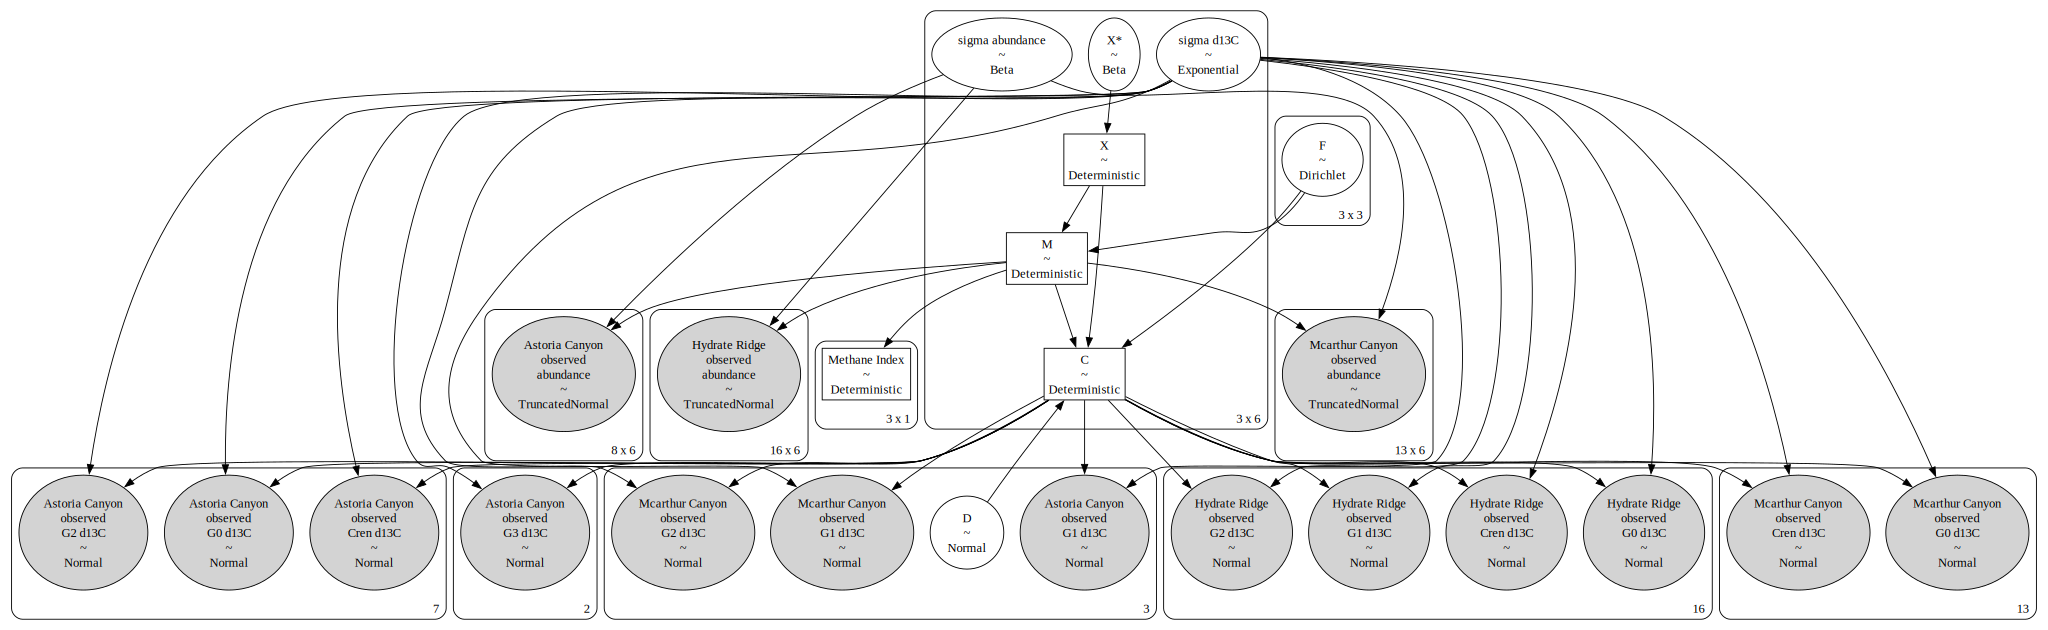

In [17]:
pm.model_to_graphviz(model)

### prior predictive checks

In [18]:
with model:
    prior = pm.sample_prior_predictive(samples=32_000)
prior.prior.to_netcdf("../model-results/prior.nc")

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, D, F, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance, X*, sigma abundance, sigma d13C]


<Figure size 960x720 with 0 Axes>

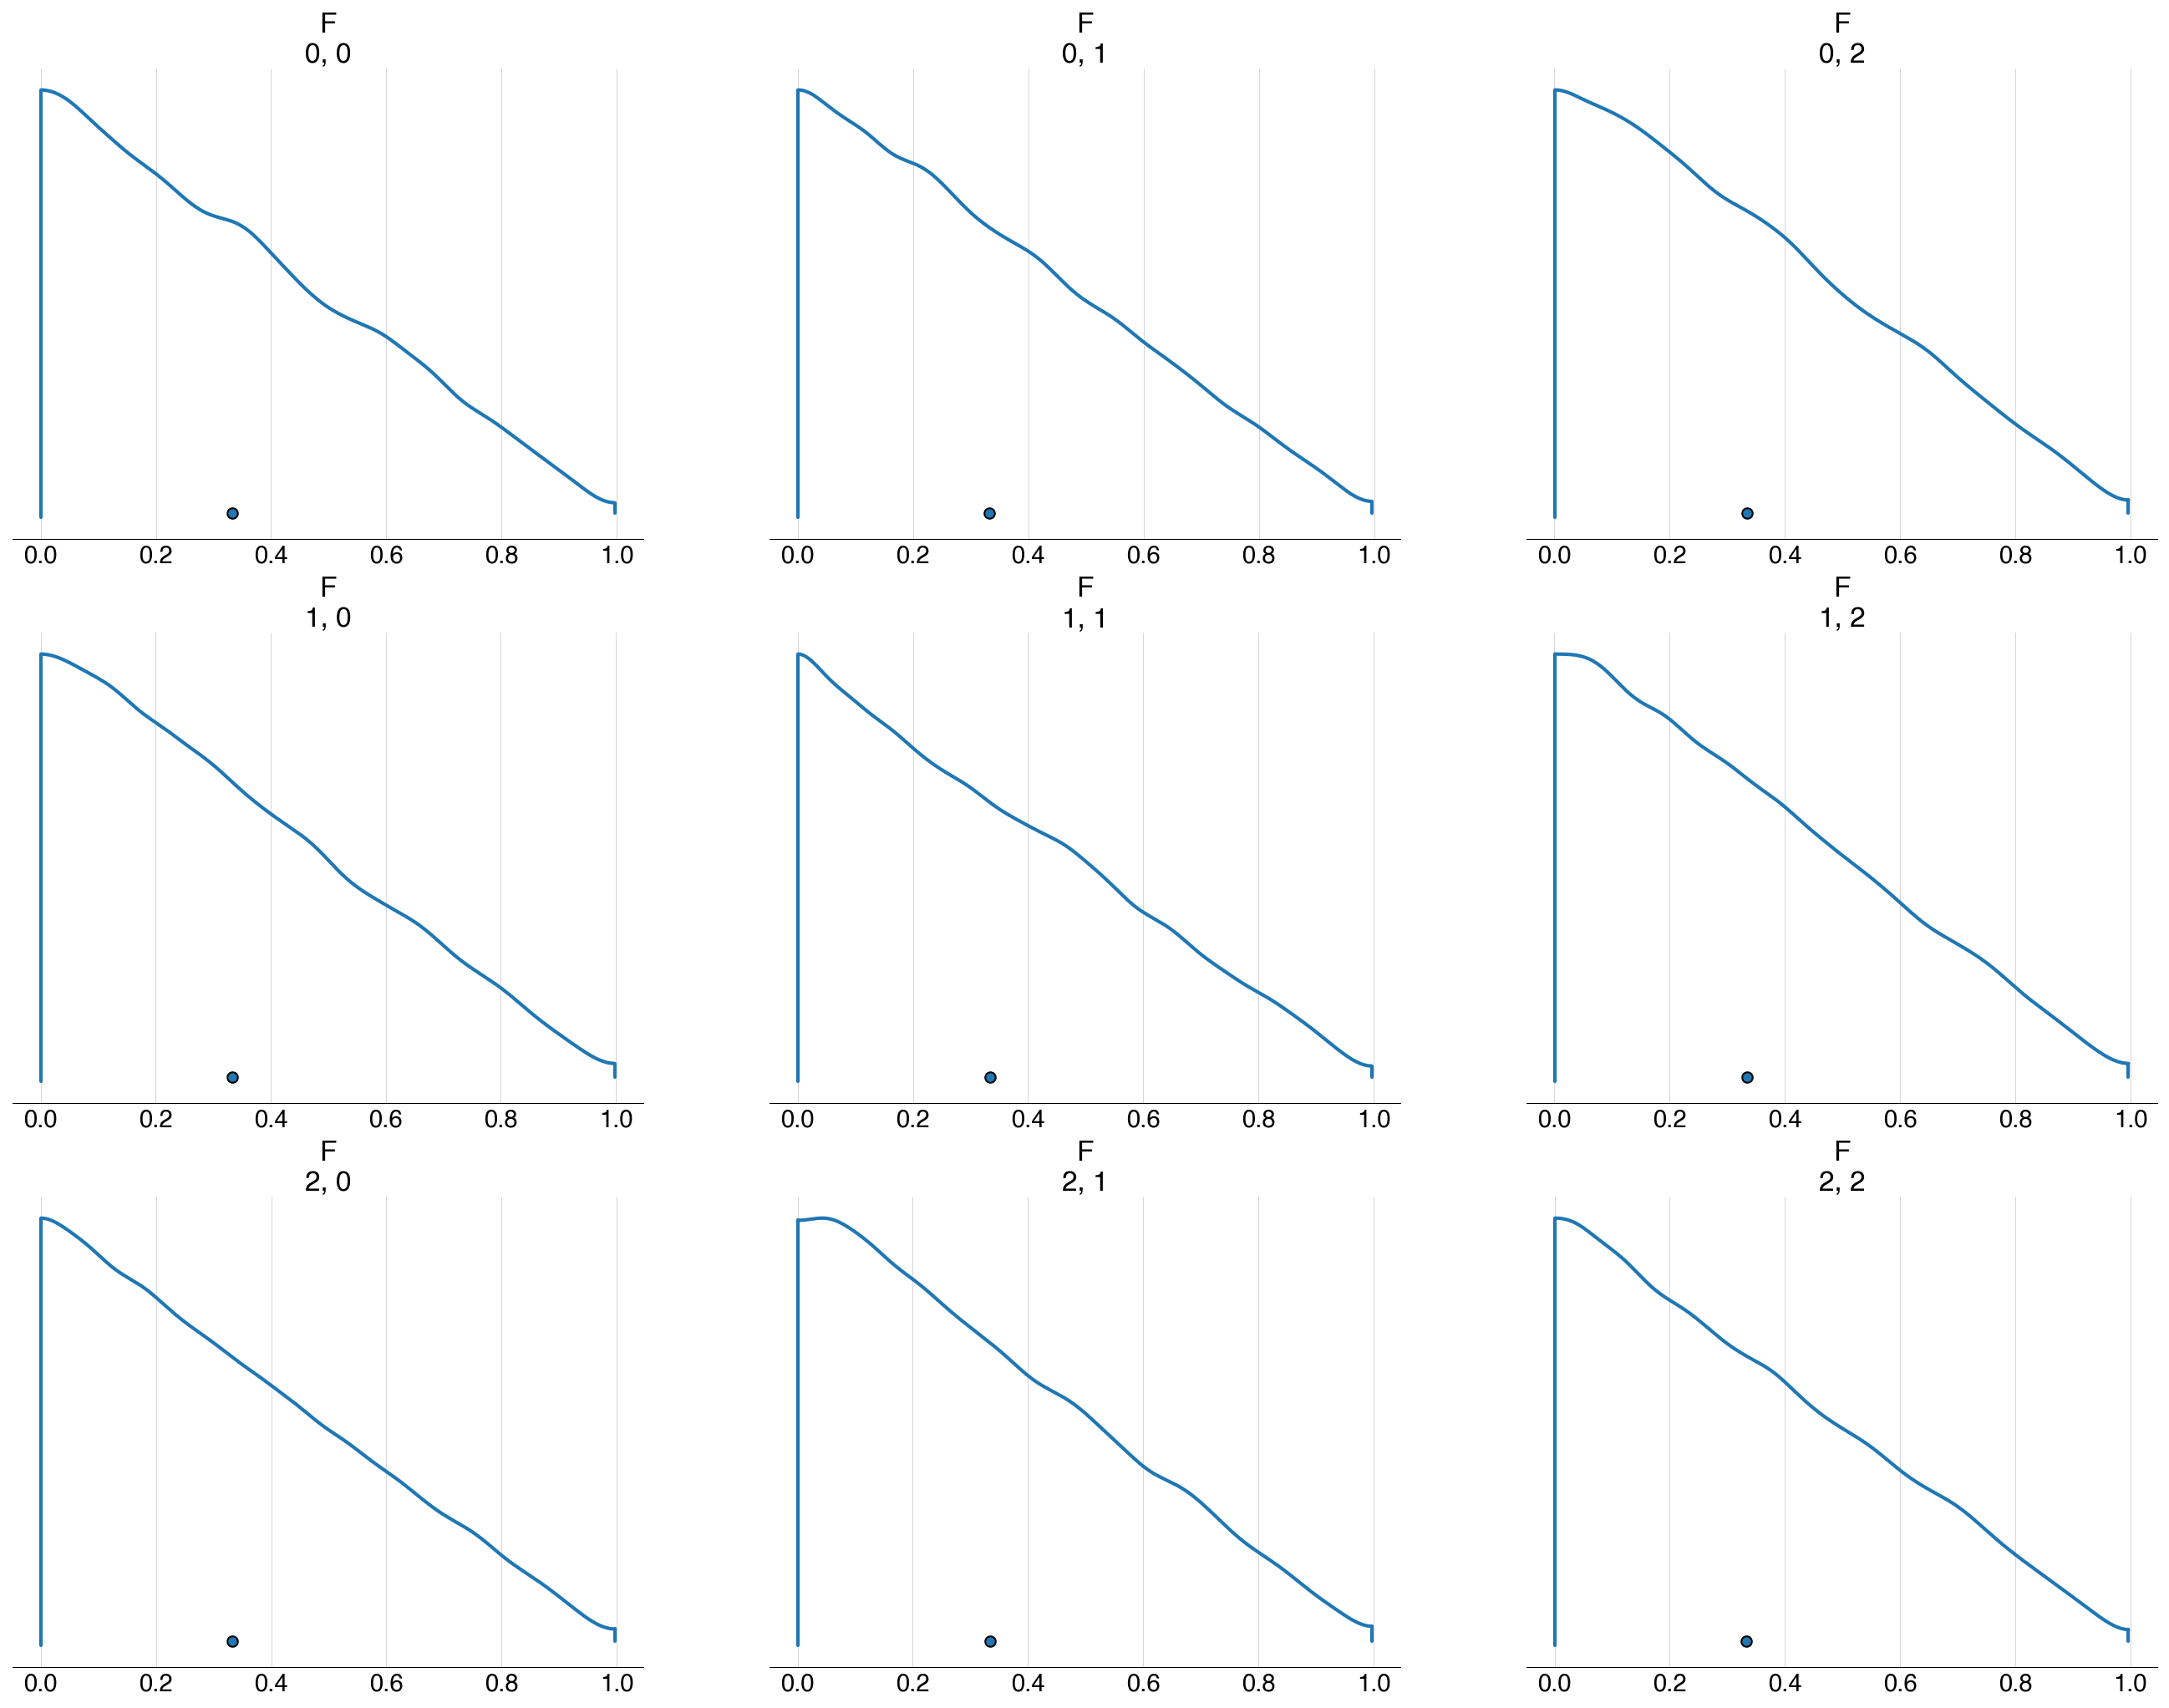

In [19]:
fig = plt.figure()
az.plot_density(prior.prior, var_names="F", hdi_prob=1, grid=(3, 3))
fig.tight_layout()

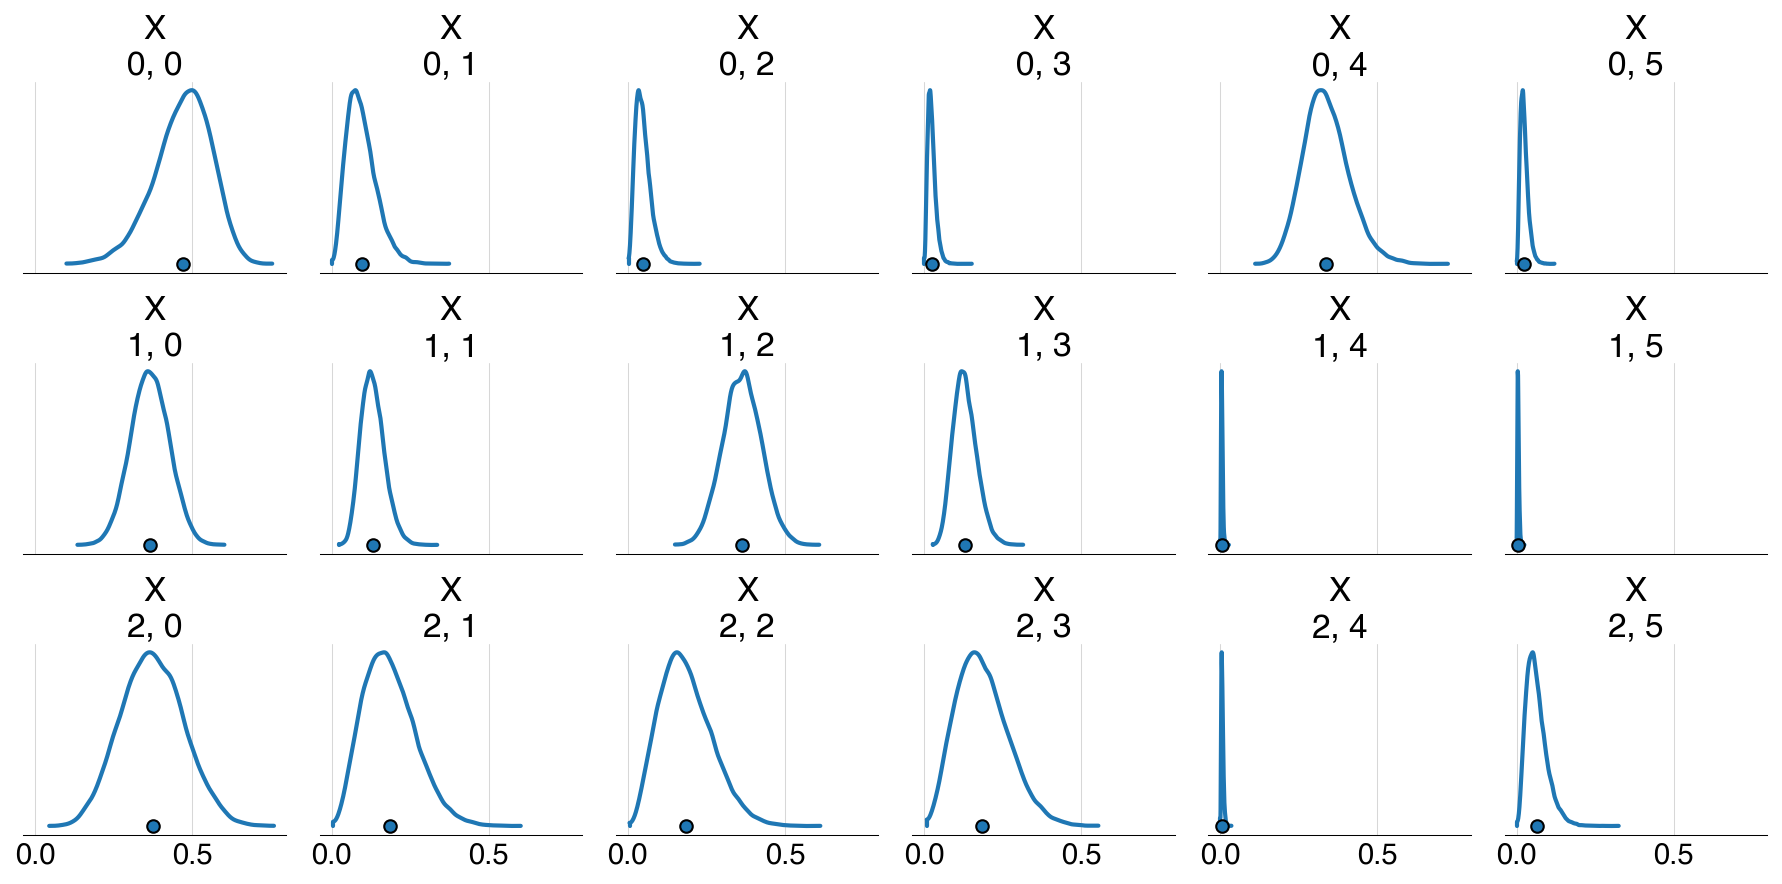

In [20]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="X", hdi_prob=1, ax=axs)
fig.tight_layout()

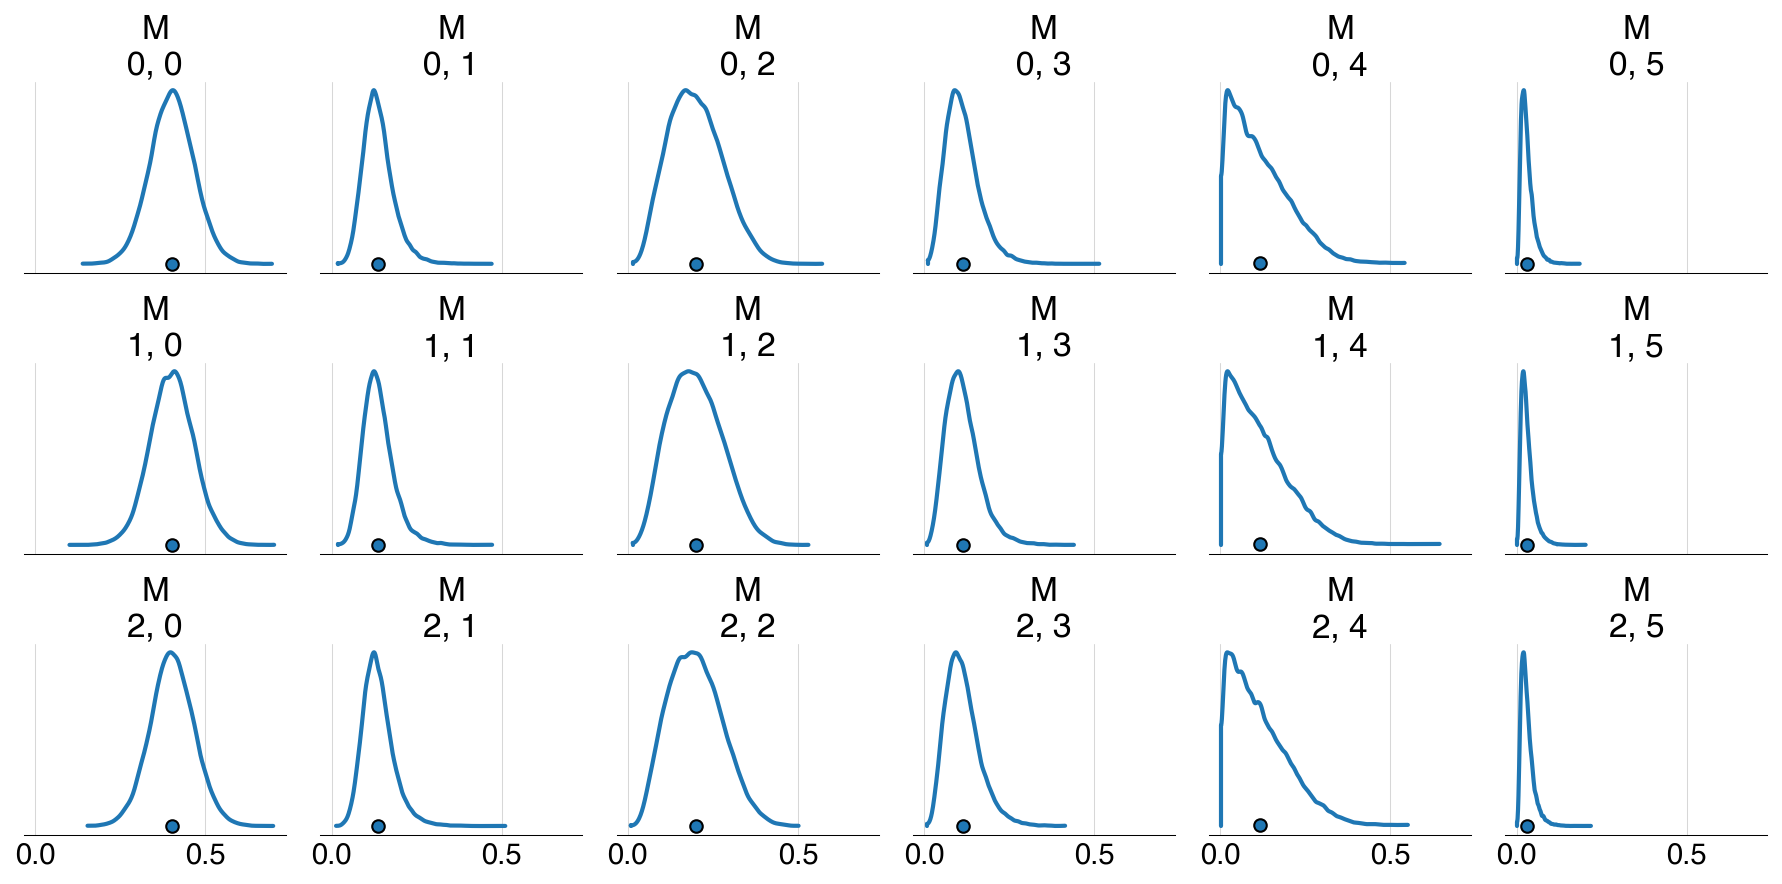

In [21]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="M", hdi_prob=1, ax=axs)
fig.tight_layout()

<Figure size 960x720 with 0 Axes>

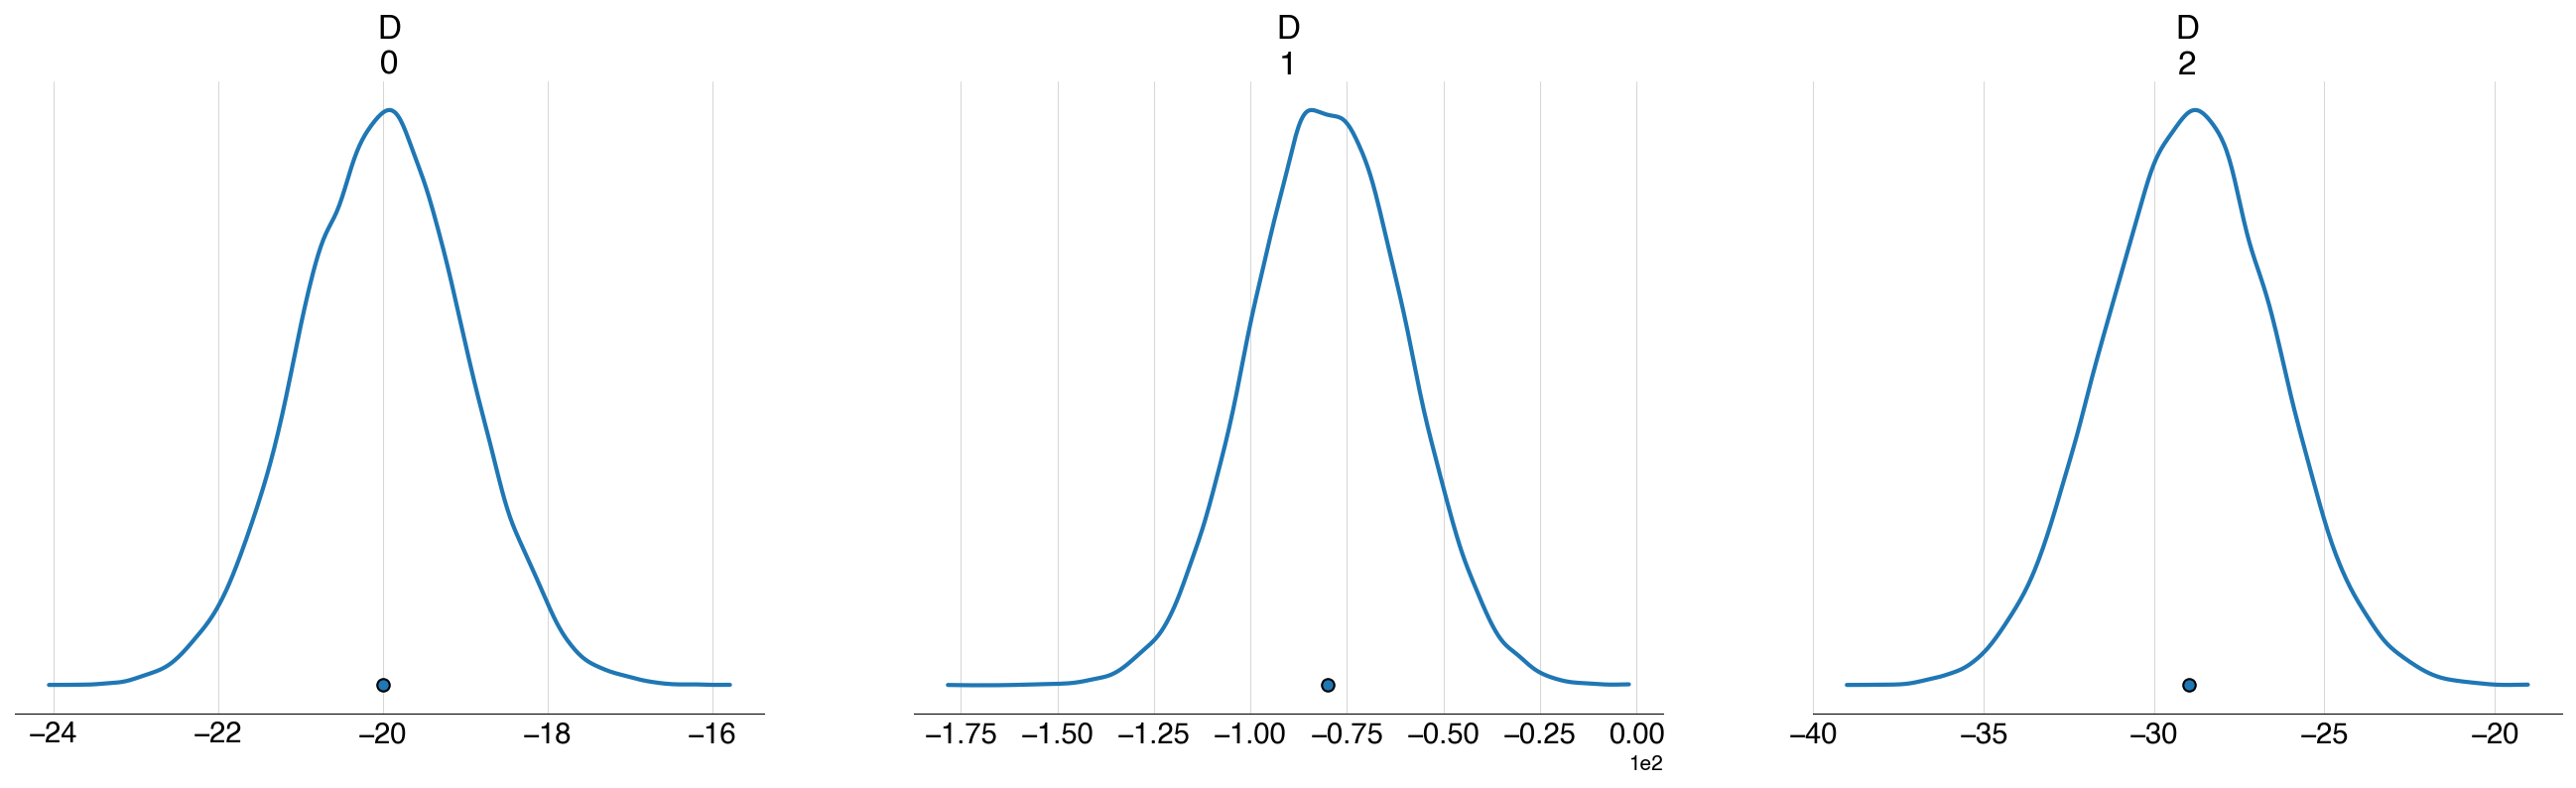

In [22]:
fig = plt.figure()
az.plot_density(prior.prior, var_names="D", hdi_prob=1)
fig.tight_layout()

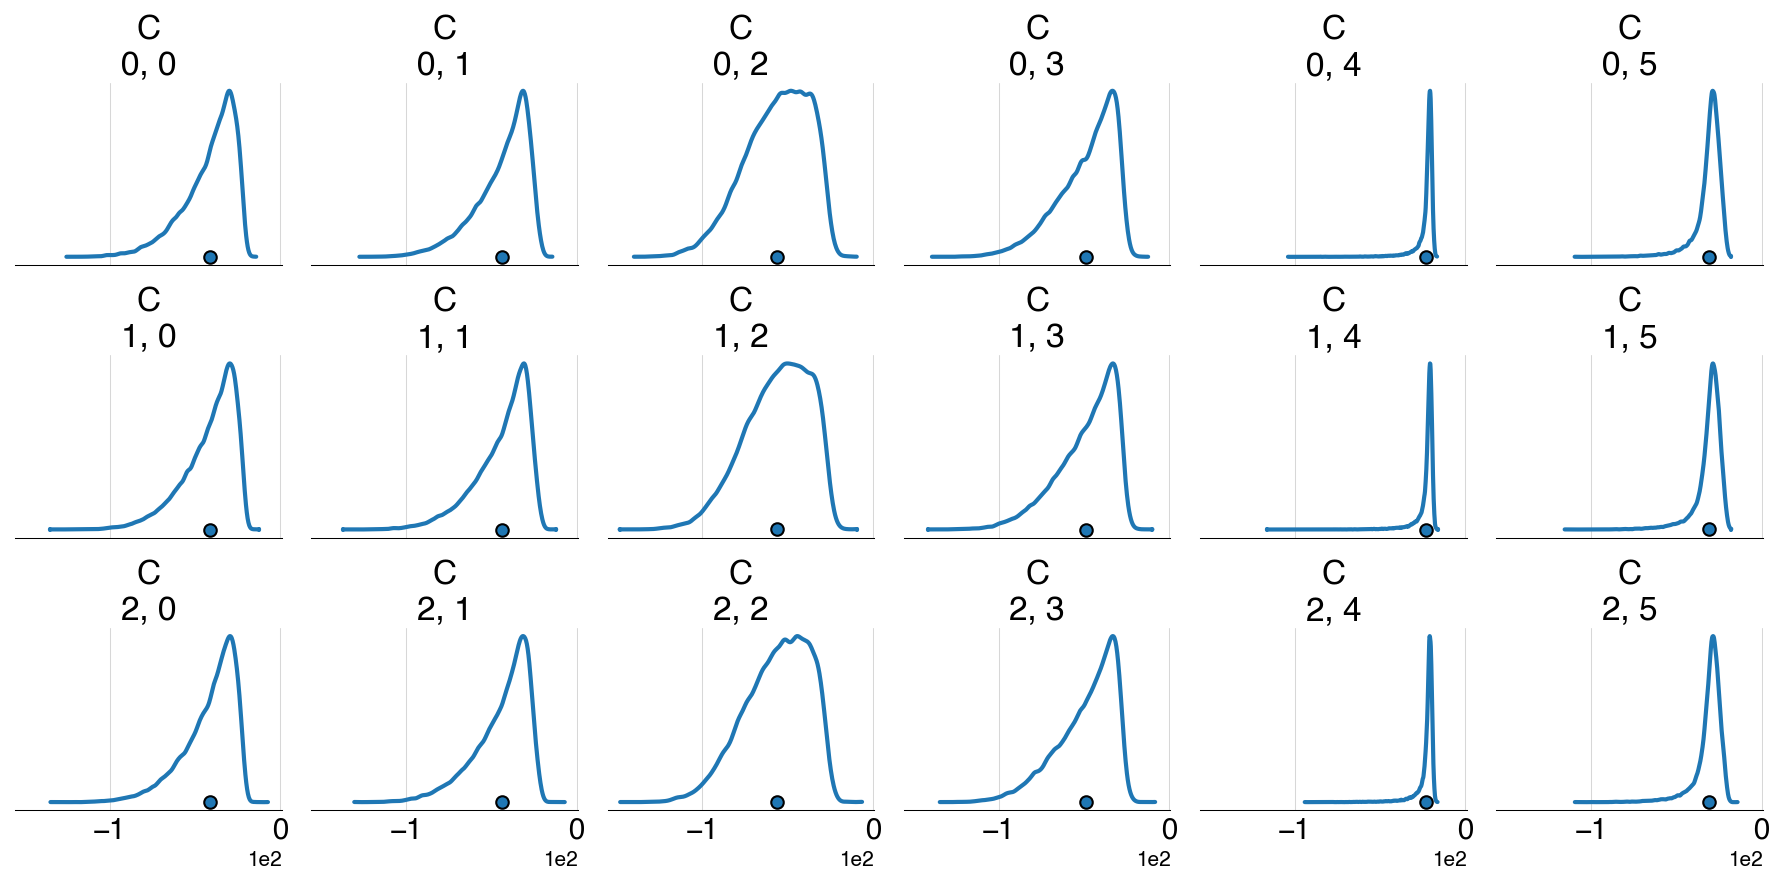

In [23]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6), sharex=True)
az.plot_density(prior.prior, var_names="C", hdi_prob=1, ax=axs)
fig.tight_layout()

### posterior sampling

In [24]:
with model:
    post = pm.sample(cores=16, chains=16, tune=4_000, draws=16_000, target_accept=0.975)
post.posterior.to_netcdf("../model-results/posterior.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [F, X*, sigma abundance, D, sigma d13C]


Sampling 16 chains for 4_000 tune and 16_000 draw iterations (64_000 + 256_000 draws total) took 1430 seconds.


### posterior checks

### rhat

In [25]:
rhat = az.rhat(post)

In [26]:
rhat["F"]

<xarray.DataArray 'F' (F_dim_0: 3, F_dim_1: 3)> Size: 72B
array([[1.00001493, 1.0000359 , 1.0001362 ],
       [1.0005163 , 1.00007277, 1.00066088],
       [1.00064044, 1.00019559, 1.00063154]])
Coordinates:
  * F_dim_0  (F_dim_0) int64 24B 0 1 2
  * F_dim_1  (F_dim_1) int64 24B 0 1 2

In [27]:
rhat["X"]

<xarray.DataArray 'X' (X_dim_0: 3, X_dim_1: 6)> Size: 144B
array([[1.00005567, 1.00046871, 1.0002246 , 1.00002669, 1.00061795,
        1.00073848],
       [1.00001411, 1.00007499, 1.00005422, 1.00000006, 1.00003828,
        1.00008369],
       [1.00008642, 1.00009033, 1.00009422, 1.00053514, 1.00001653,
        1.00031242]])
Coordinates:
  * X_dim_0  (X_dim_0) int64 24B 0 1 2
  * X_dim_1  (X_dim_1) int64 48B 0 1 2 3 4 5

In [28]:
rhat["D"]

<xarray.DataArray 'D' (D_dim_0: 3)> Size: 24B
array([1.0000138 , 1.00011751, 1.00006525])
Coordinates:
  * D_dim_0  (D_dim_0) int64 24B 0 1 2

#### ESS

In [29]:
ess = az.ess(post)

In [30]:
ess["F"]

<xarray.DataArray 'F' (F_dim_0: 3, F_dim_1: 3)> Size: 72B
array([[227751.16793417, 185748.35205271,  67953.26991929],
       [ 39257.91232272, 185201.62591346,  32131.27640687],
       [ 30371.59172798,  64095.22001169,  29857.41036504]])
Coordinates:
  * F_dim_0  (F_dim_0) int64 24B 0 1 2
  * F_dim_1  (F_dim_1) int64 24B 0 1 2

In [31]:
ess["X"]

<xarray.DataArray 'X' (X_dim_0: 3, X_dim_1: 6)> Size: 144B
array([[201125.47957761,  49272.31212955,  83149.89365319,
        138920.51575341,  32637.13579716,  29768.23378676],
       [285384.18761917, 362464.0748706 , 298987.82108448,
        231593.67843823, 248732.90795925, 199507.53881087],
       [194652.96315925, 168767.09545311, 152084.38712603,
         38728.28187806, 261915.47314412,  52106.90161856]])
Coordinates:
  * X_dim_0  (X_dim_0) int64 24B 0 1 2
  * X_dim_1  (X_dim_1) int64 48B 0 1 2 3 4 5

In [32]:
ess["D"]

<xarray.DataArray 'D' (D_dim_0: 3)> Size: 24B
array([228914.3706631 , 101797.63141469, 269883.01432315])
Coordinates:
  * D_dim_0  (D_dim_0) int64 24B 0 1 2

#### traces

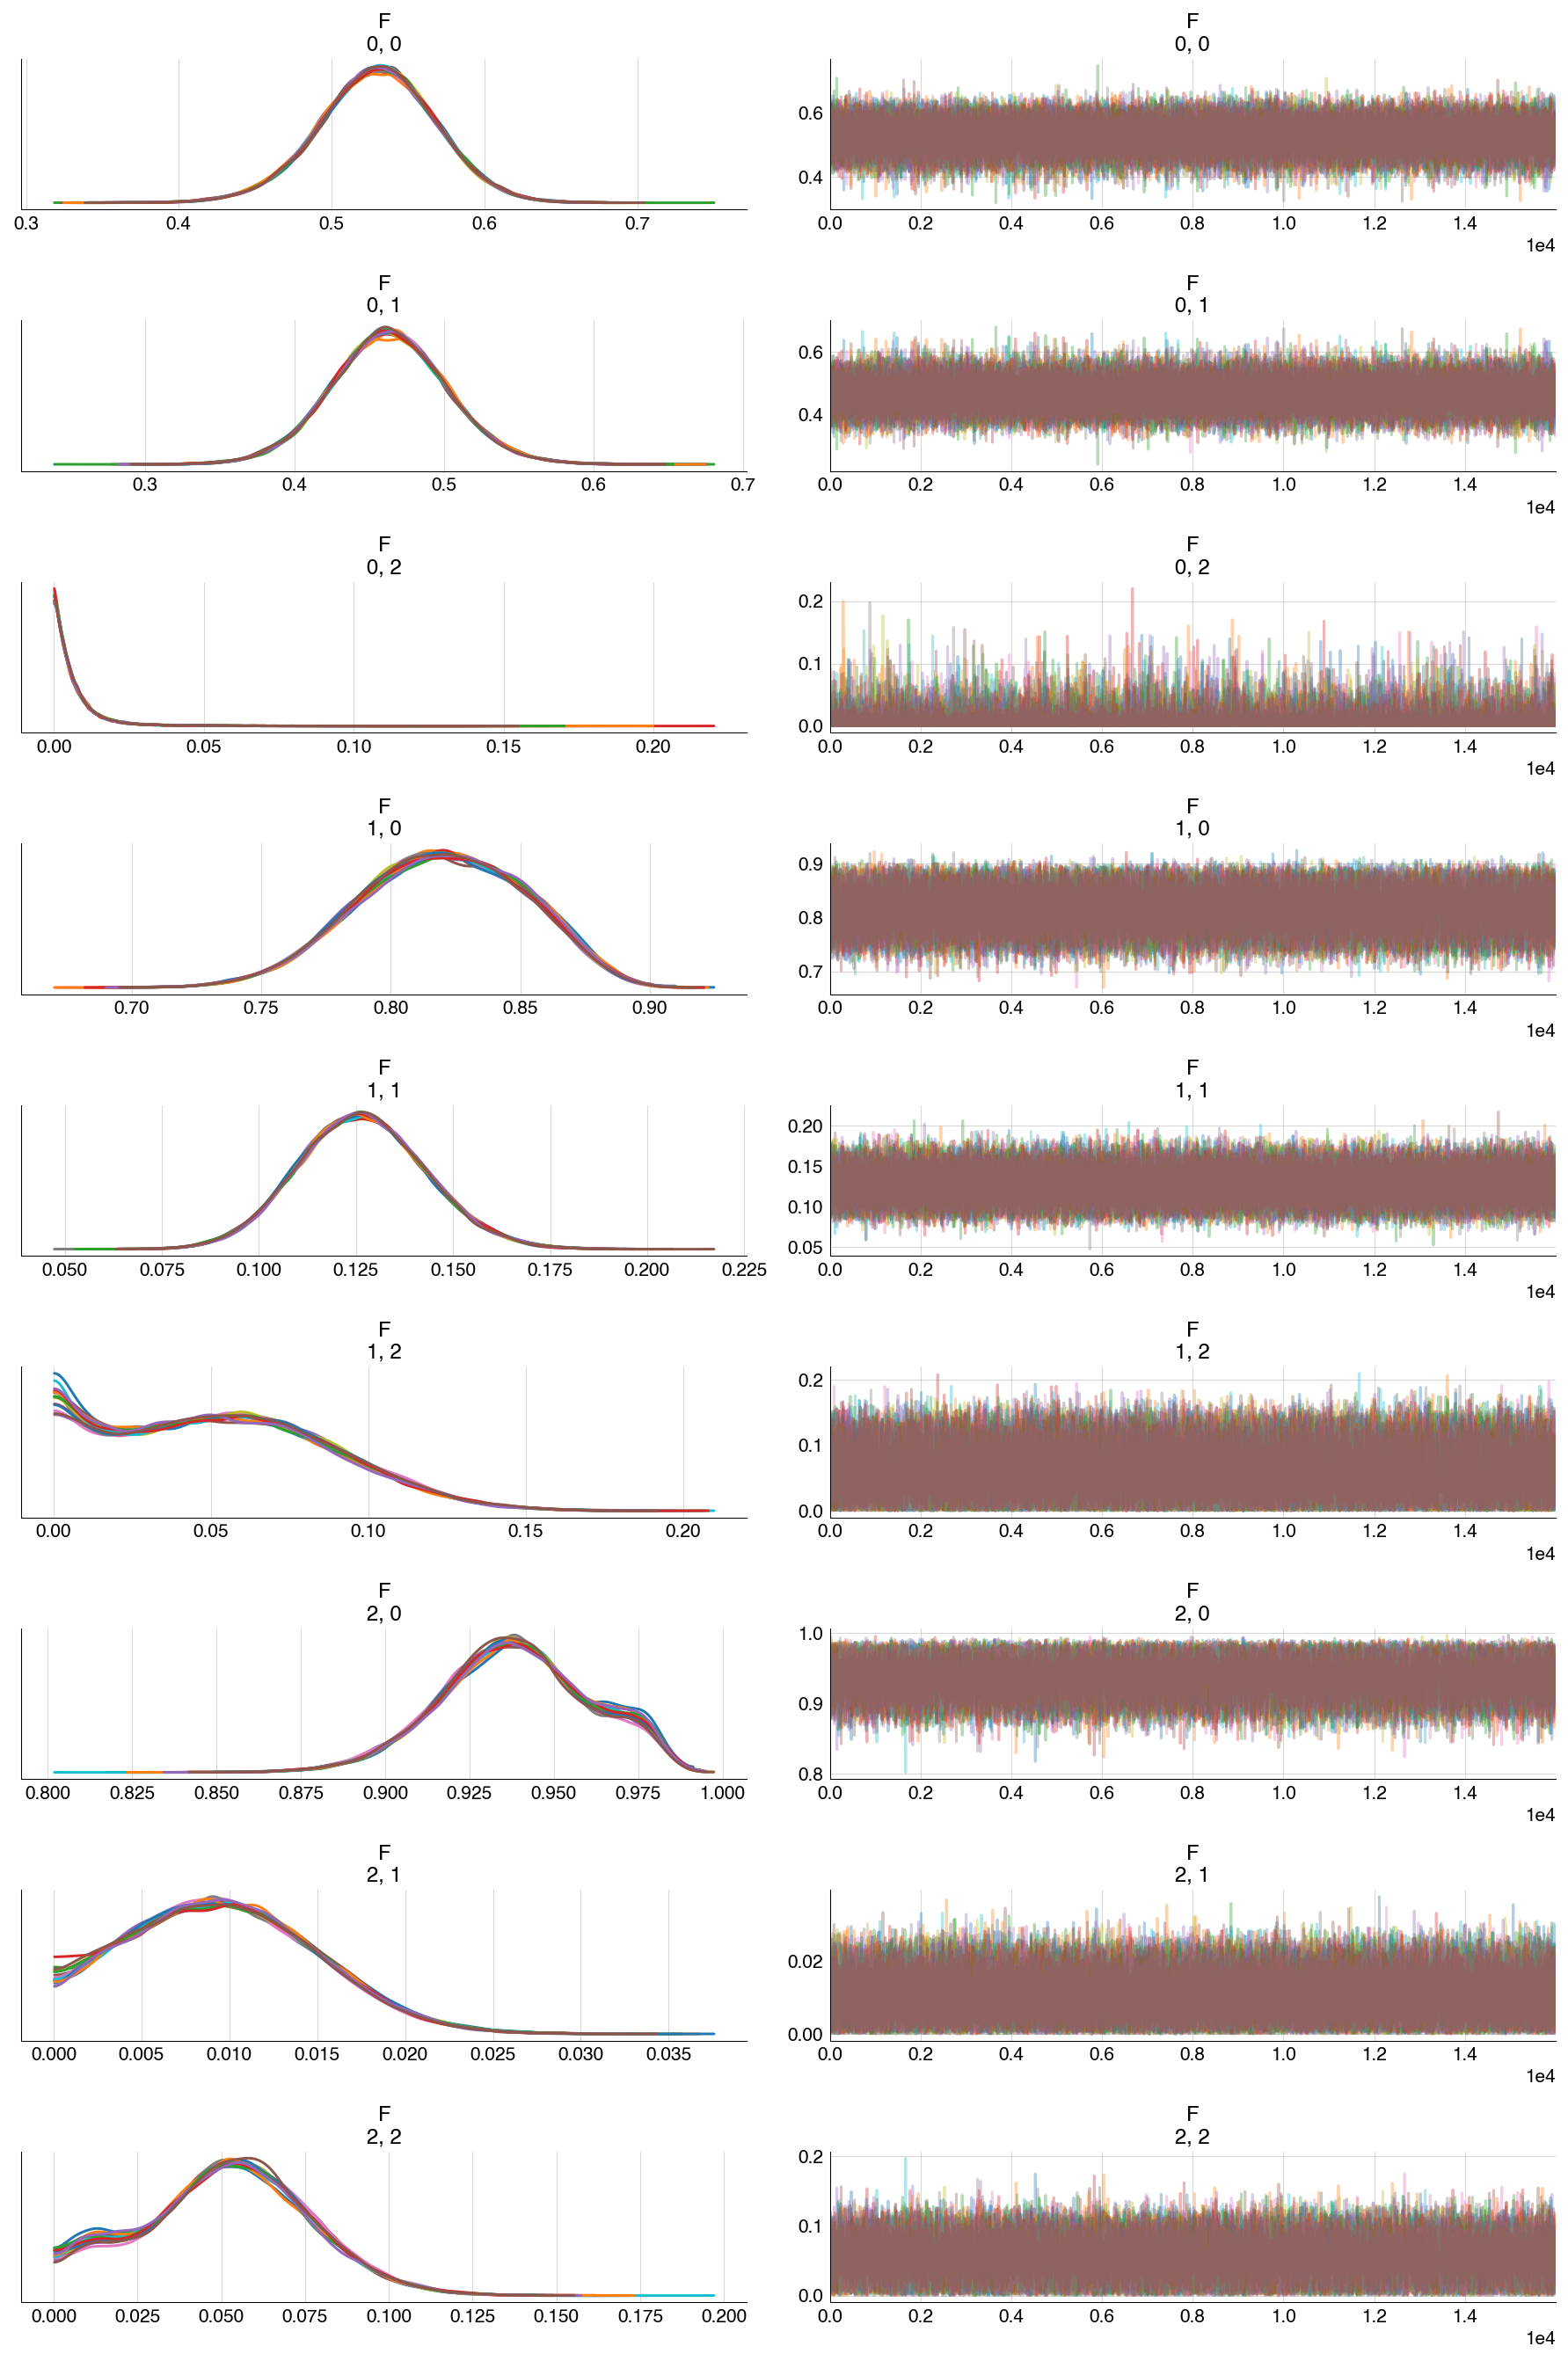

In [33]:
az.plot_trace(post, var_names=["F"], compact=False)
plt.gcf().tight_layout()

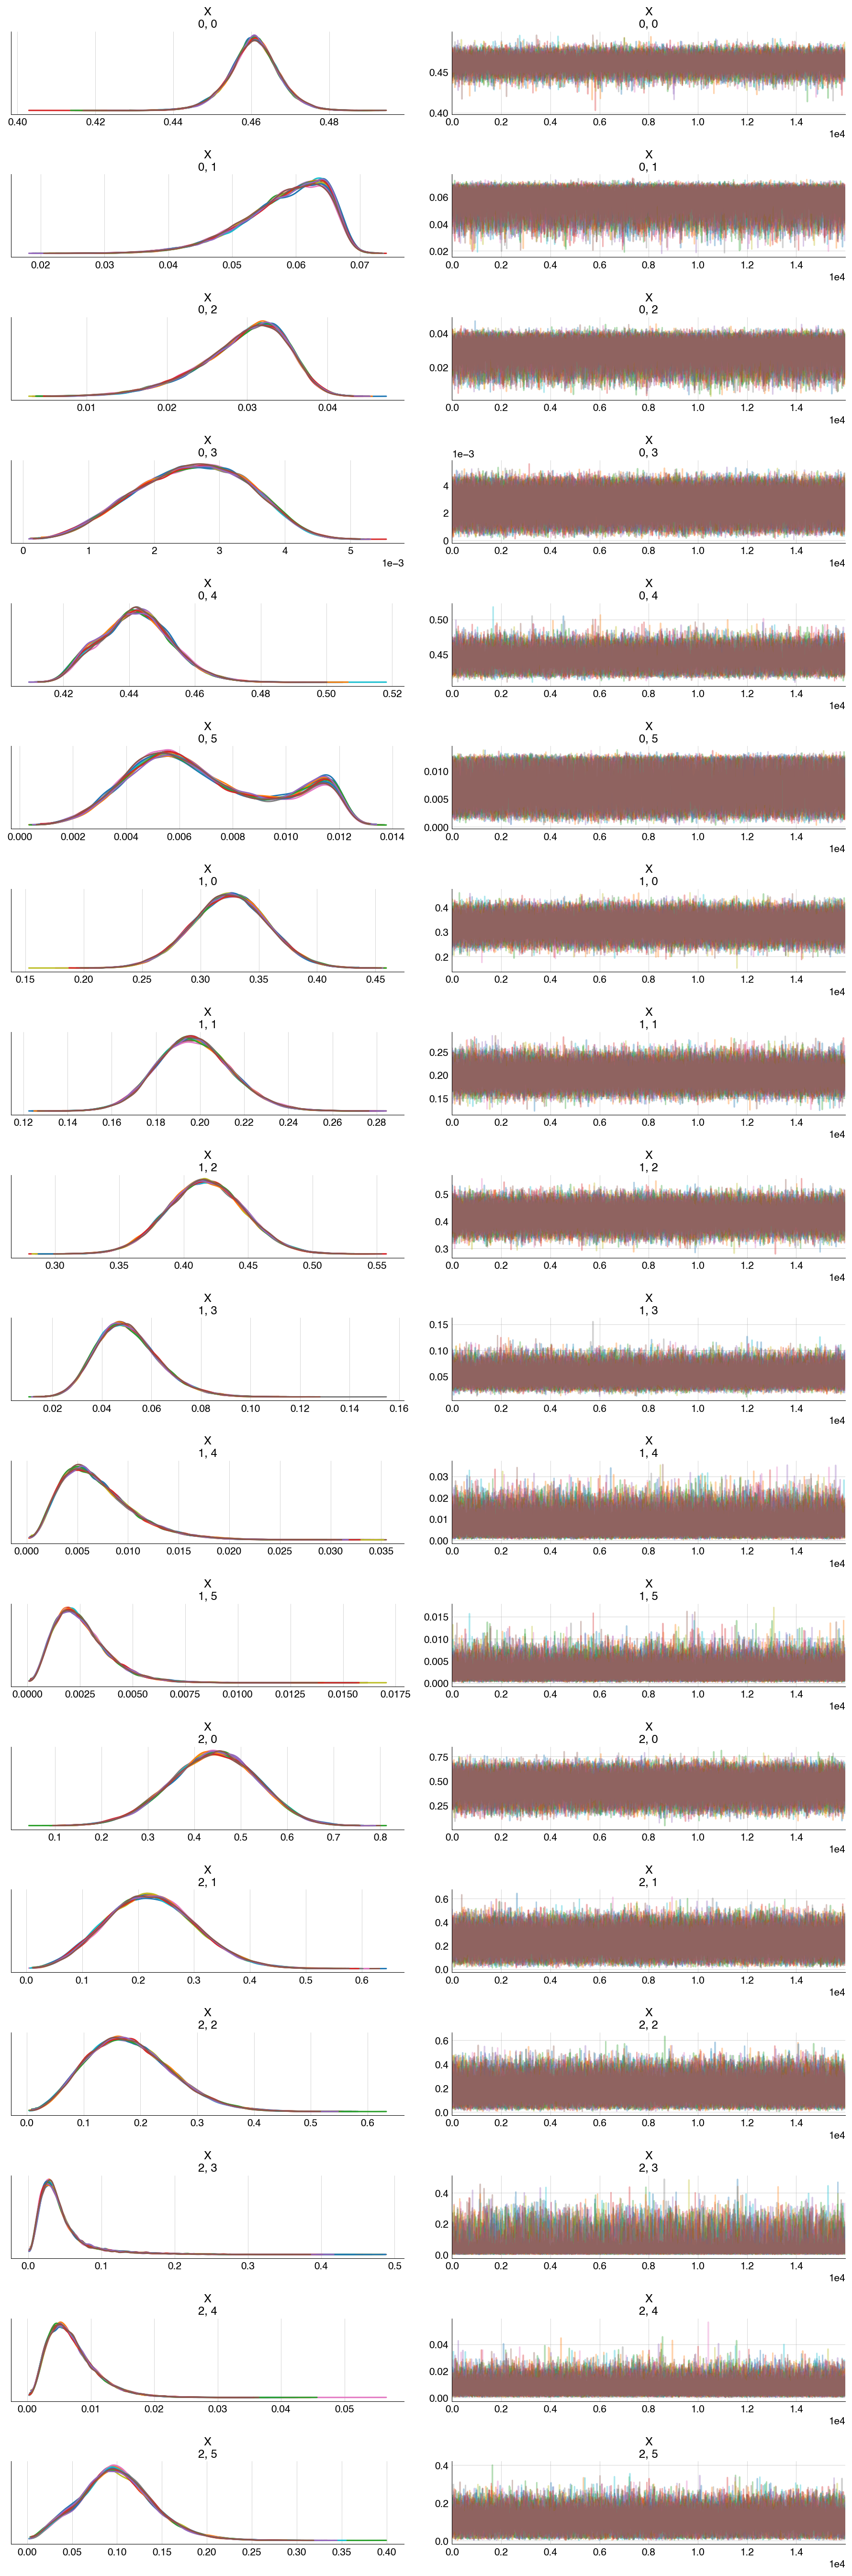

In [34]:
az.plot_trace(post, var_names="X", compact=False)
plt.gcf().tight_layout()

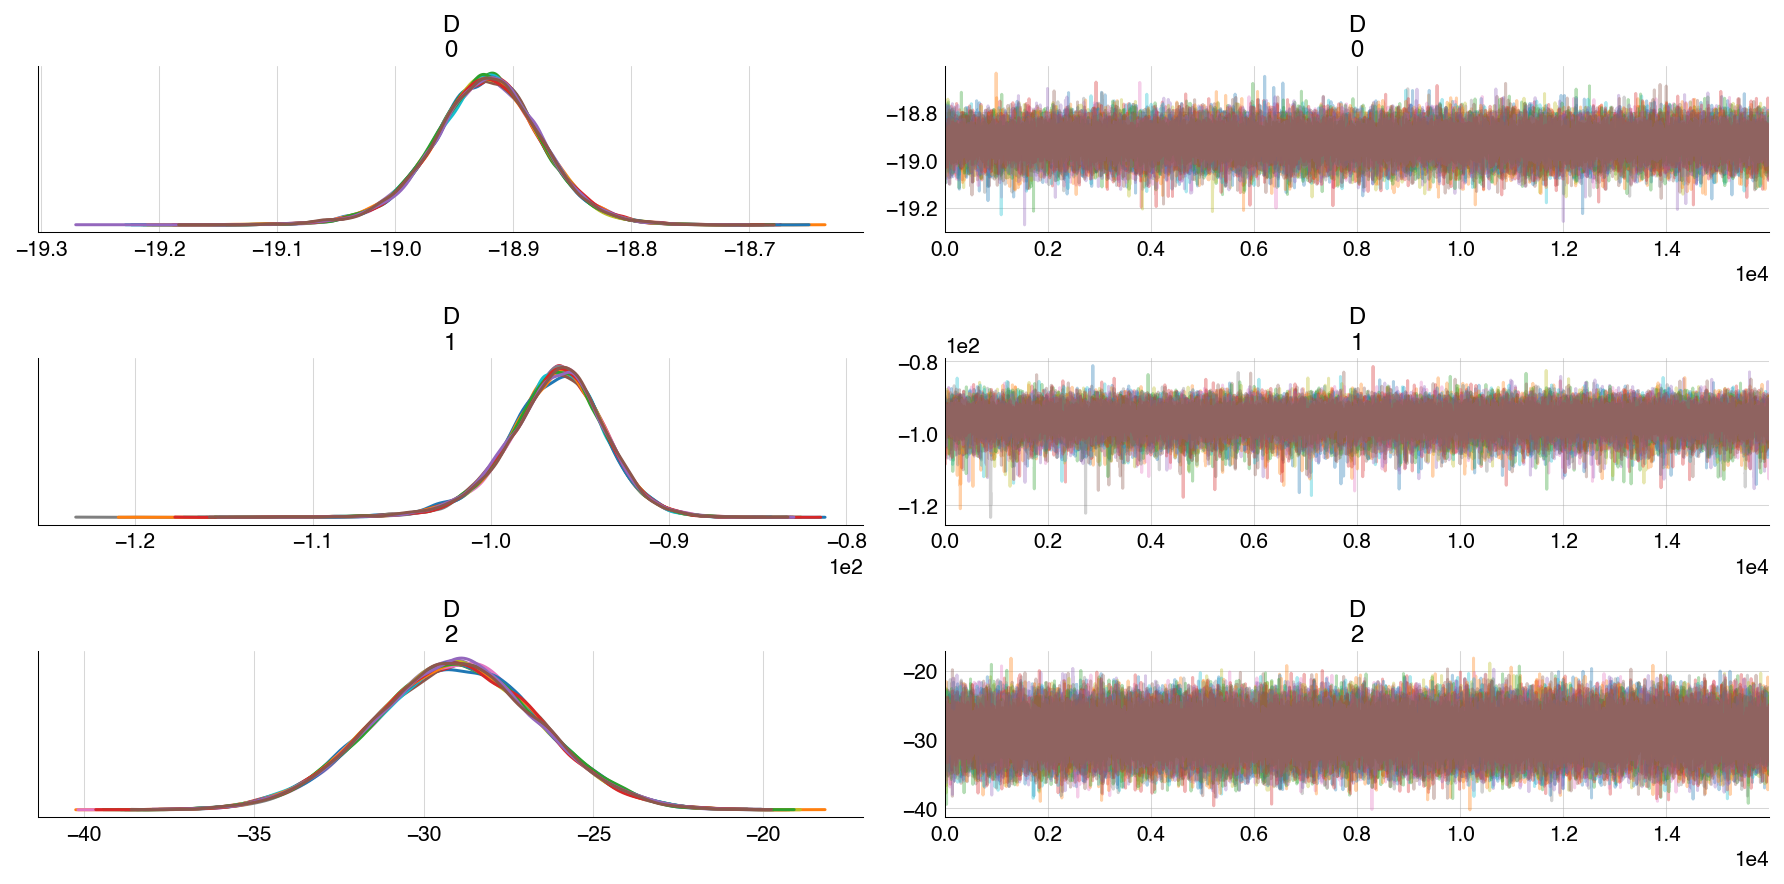

In [35]:
az.plot_trace(post, var_names=["D"], compact=False)
plt.gcf().tight_layout()

### posterior predictive

In [36]:
with model:
    ppc = pm.sample_posterior_predictive(post)
ppc.posterior_predictive.to_netcdf("../model-results/posterior_predictive.nc")

Sampling: [Astoria Canyon
observed
Cren d13C, Astoria Canyon
observed
G0 d13C, Astoria Canyon
observed
G1 d13C, Astoria Canyon
observed
G2 d13C, Astoria Canyon
observed
G3 d13C, Astoria Canyon
observed
abundance, Hydrate Ridge
observed
Cren d13C, Hydrate Ridge
observed
G0 d13C, Hydrate Ridge
observed
G1 d13C, Hydrate Ridge
observed
G2 d13C, Hydrate Ridge
observed
abundance, Mcarthur Canyon
observed
Cren d13C, Mcarthur Canyon
observed
G0 d13C, Mcarthur Canyon
observed
G1 d13C, Mcarthur Canyon
observed
G2 d13C, Mcarthur Canyon
observed
abundance]


/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


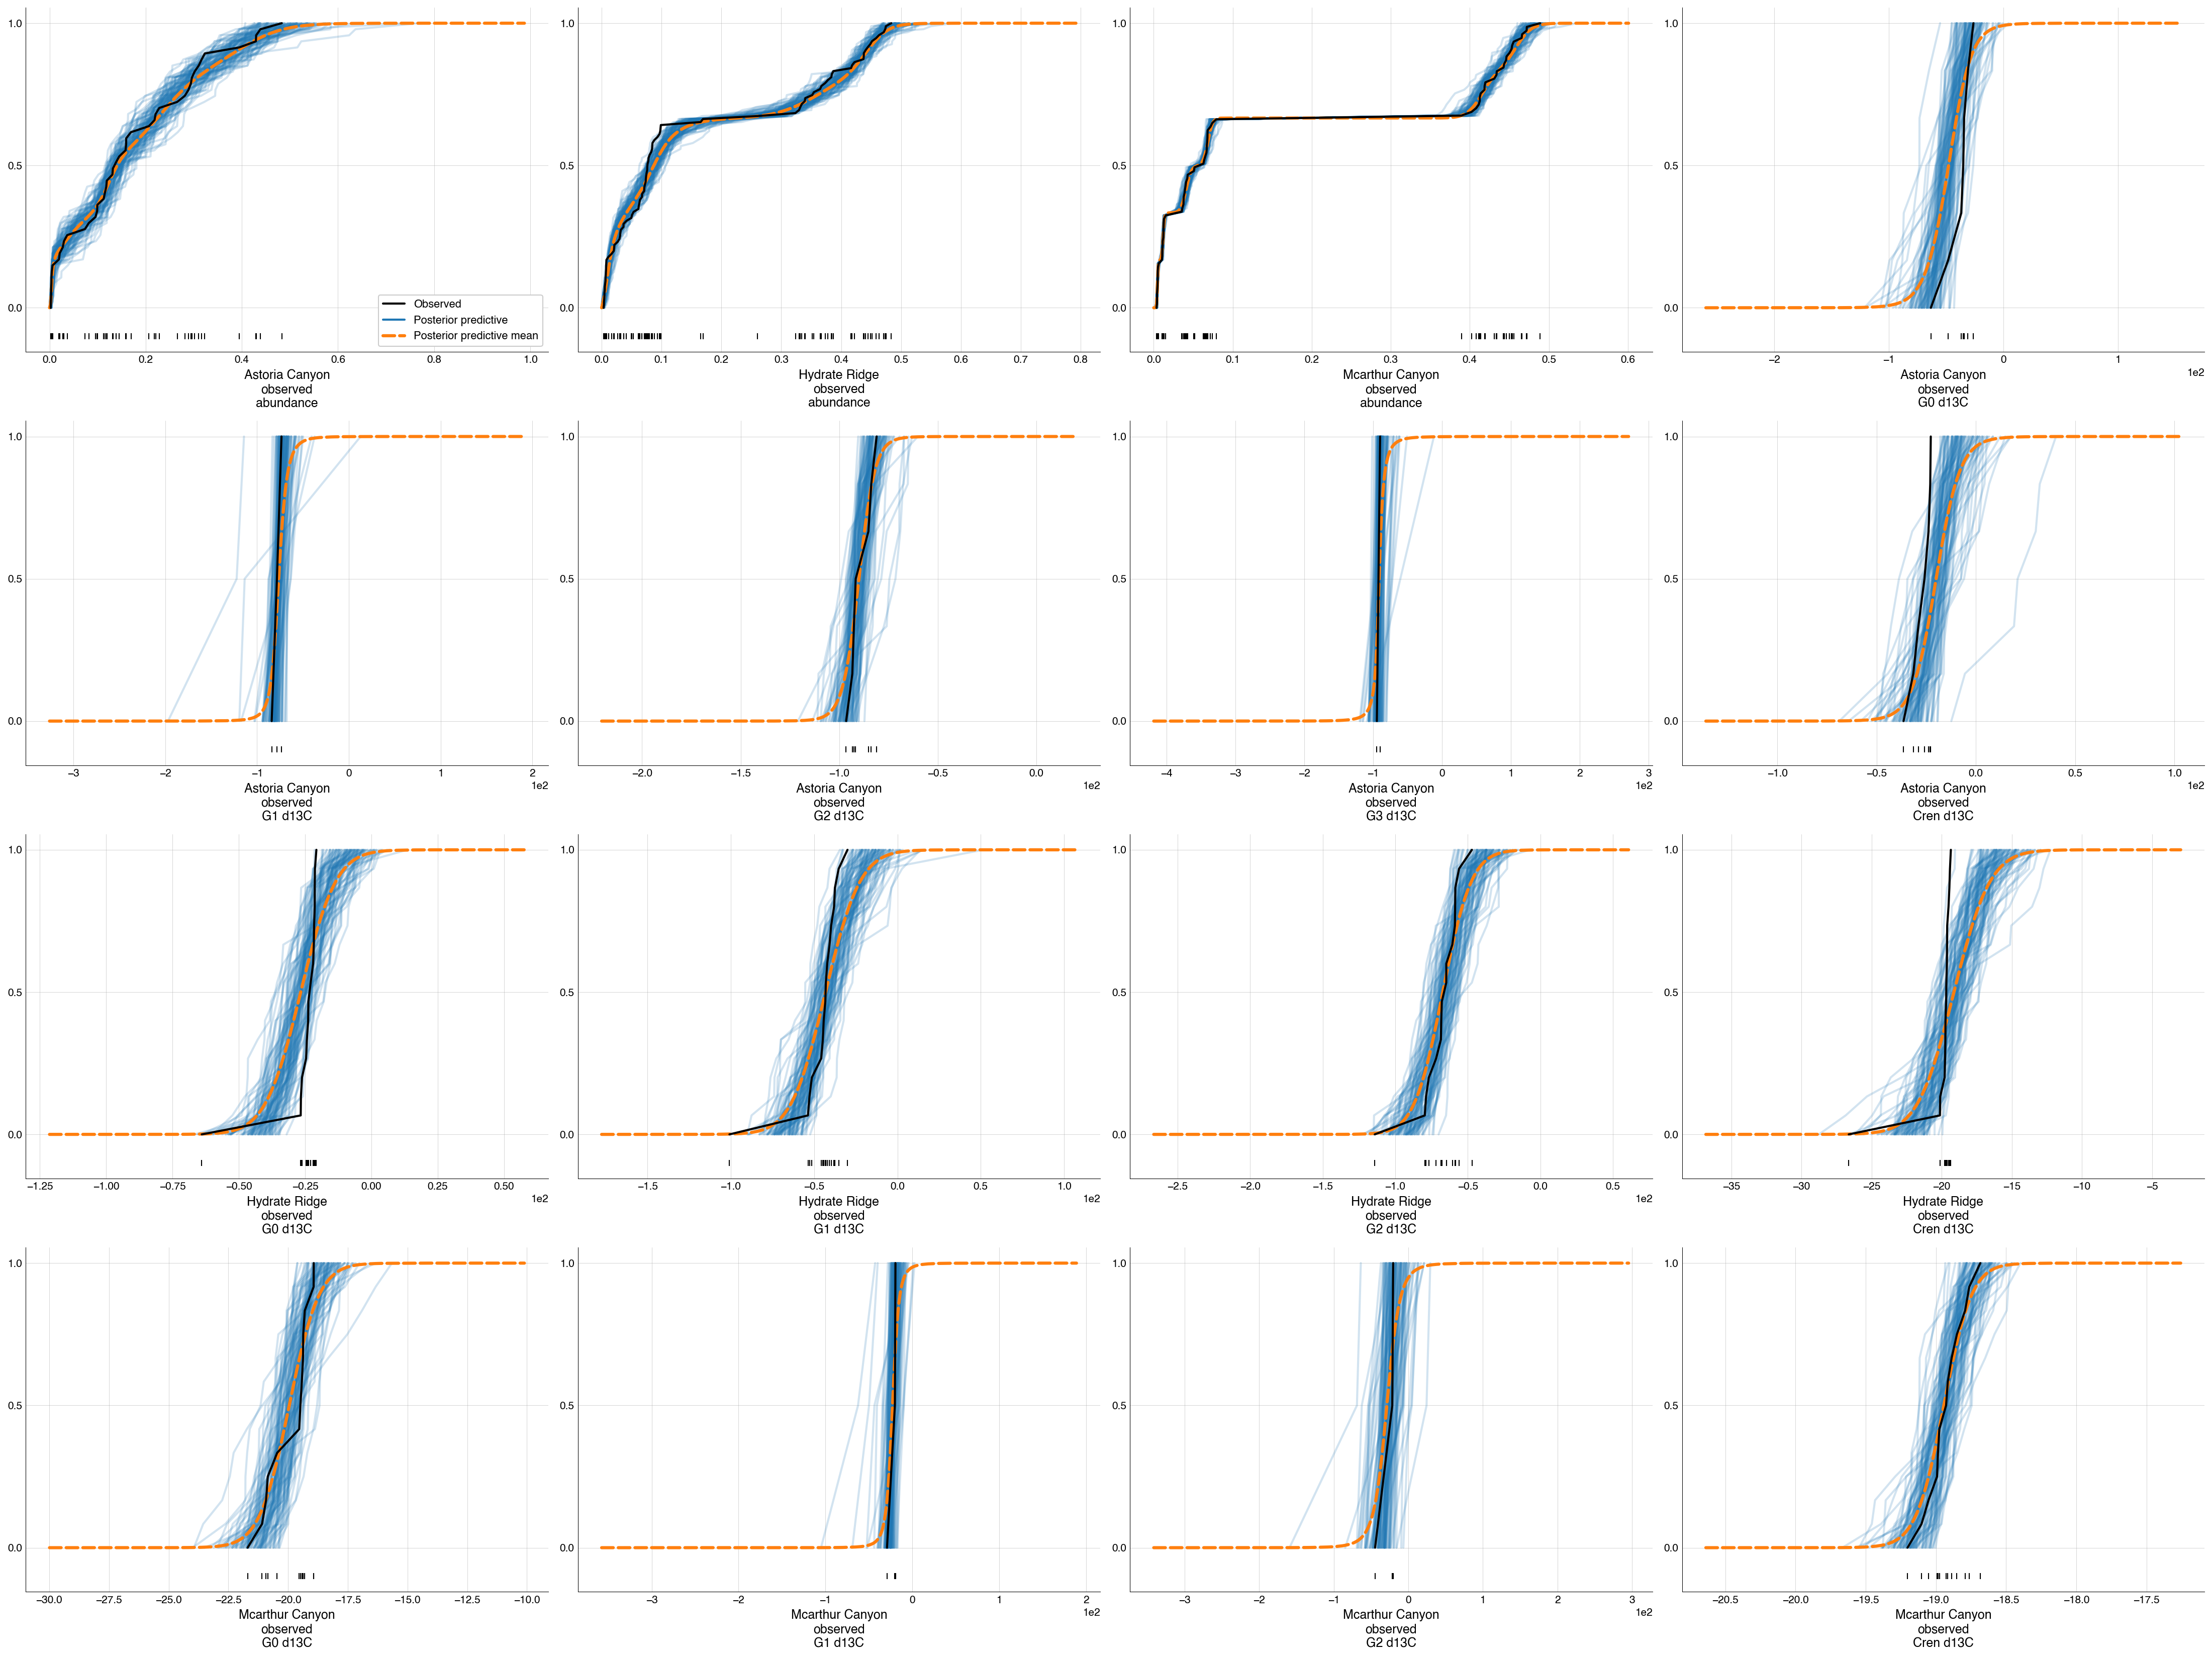

In [37]:
az.plot_ppc(ppc, num_pp_samples=100, observed_rug=True, kind="cumulative")
plt.gcf().tight_layout()